In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from source.network.ravepqmf import PQMF
import librosa
from source.network.metrics import spectral_distance, multiscale_stft

def load_audio(file_path, sr=44100):
    audio, _ = librosa.load(file_path, sr=sr)
    return torch.from_numpy(audio).float().unsqueeze(0).unsqueeze(0)


def plot_waveform(signal, title):
    plt.figure(figsize=(12, 4))
    plt.plot(signal.squeeze().numpy())
    plt.title(title)
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.show()

def plot_spectrogram(signal, sr, title):
    D = librosa.stft(signal.squeeze().numpy())
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()

# Helper Functions
def generate_sine_wave(freq, duration=1, sample_rate=44100):
    t = np.linspace(0, duration, int(duration * sample_rate), endpoint=False)
    signal = np.sin(2 * np.pi * freq * t)
    return torch.from_numpy(signal).float().unsqueeze(0).unsqueeze(0)

def generate_sample_signal(duration=1, sample_rate=44100):
    t = np.linspace(0, duration, int(duration * sample_rate), endpoint=False)
    signal = np.sin(2 * np.pi * 440 * t) + 0.5 * np.sin(2 * np.pi * 880 * t)
    return torch.from_numpy(signal).float().unsqueeze(0).unsqueeze(0)

def plot_time_domain(signal, title):
    # plt.figure(figsize=(12, 4))
    # plt.plot(signal.squeeze().numpy())
    # plt.title(title)
    # plt.xlabel('Sample')
    # plt.ylabel('Amplitude')
    # plt.show()
    plt.figure(figsize=(20, 6))  # Make the figure wider
    plt.plot(signal.squeeze().numpy()[:1000], '.', markersize=1)  # Plot first 1000 samples as points
    plt.title("Original Signal (Time Domain)")
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    plt.show()

def plot_frequency_domain(signal, sample_rate=44100, title=''):
    fft = np.fft.fft(signal.squeeze().numpy())
    freqs = np.fft.fftfreq(len(fft), 1/sample_rate)
    plt.figure(figsize=(12, 4))
    plt.plot(freqs[:len(freqs)//2], np.abs(fft)[:len(fft)//2])
    plt.title(title)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.xscale('log')
    plt.show()

def plot_spectral_distance(x_stfts, y_stfts, scales):
    for i, scale in enumerate(scales):
        plt.figure(figsize=(12, 4))
        plt.imshow(np.abs(x_stfts[i][0] - y_stfts[i][0]).numpy(), aspect='auto', cmap='viridis')
        plt.title(f'Spectral Distance (scale {scale})')
        plt.colorbar(label='Magnitude')
        plt.xlabel('Time Frame')
        plt.ylabel('Frequency Bin')
        plt.show()


Part 1: PQMF Decomposition and Reconstruction


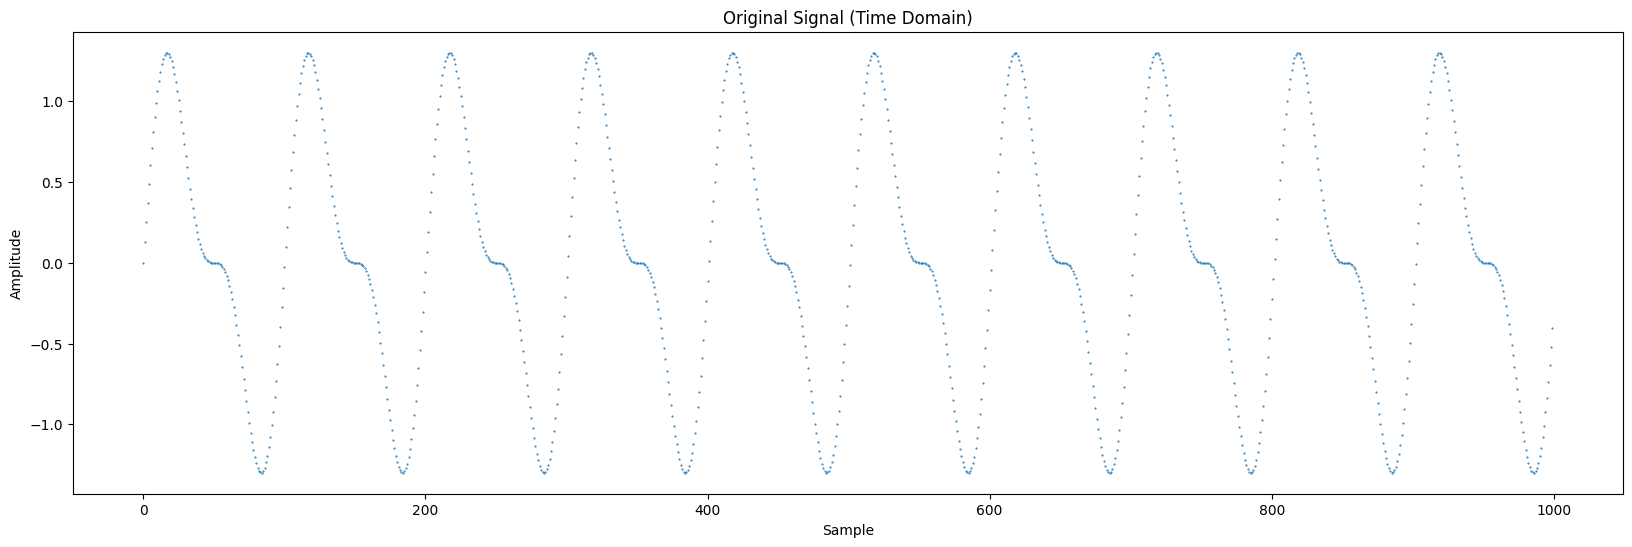

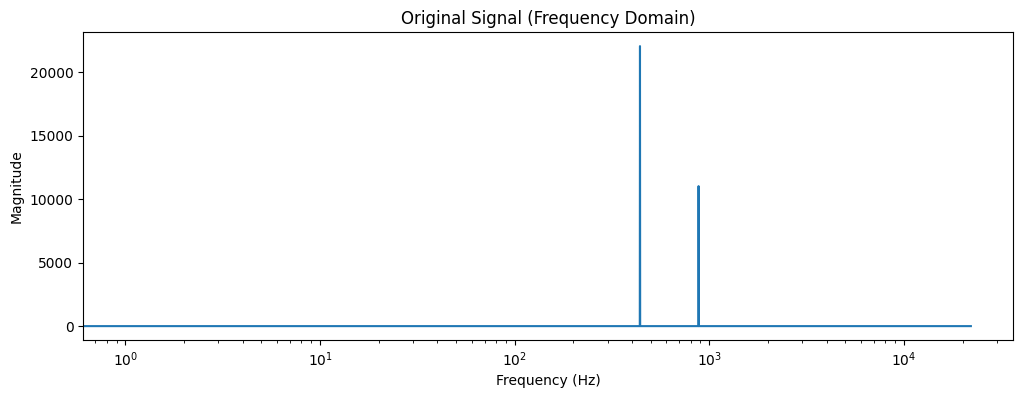

In [2]:
print("Part 1: PQMF Decomposition and Reconstruction")
signal = generate_sample_signal()
plot_time_domain(signal, "Original Signal (Time Domain)")
plot_frequency_domain(signal, title="Original Signal (Frequency Domain)")


In [ ]:
pqmf = PQMF(attenuation=80, n_band=4)
from pedalboard.io import AudioFile

with AudioFile('80s Beat 90 bpm_wet.wav') as f:
    signal = f.read(int(f.samplerate * f.duration))

decomposed = pqmf.forward(signal)
reconstructed = pqmf.inverse(decomposed)

print(decomposed.shape)

# Plot each band separately
for i in range(decomposed.shape[1]):
    signal = decomposed[0, i, :]
    plot_time_domain(signal, f"Decomposed Signal - Band {i+1} (Time Domain)")
    plot_frequency_domain(signal, title=f"Decomposed Signal - Band {i+1}")

plot_time_domain(decomposed.sum(dim=1), "Decomposed Signal (Time Domain)")
plot_frequency_domain(decomposed.sum(dim=1), title="Decomposed Signal (Frequency Domain)")

: 

In [3]:

plot_time_domain(reconstructed, "Reconstructed Signal (Time Domain)")
plot_frequency_domain(reconstructed, title="Reconstructed Signal (Frequency Domain)")

distance = spectral_distance(signal, reconstructed)
print(f"Spectral distance between original and reconstructed: {distance.item()}")

scales = [2048, 1024, 512, 256, 128]
x_stfts = multiscale_stft(signal, scales, .75)
y_stfts = multiscale_stft(reconstructed, scales, .75)

plot_spectral_distance(x_stfts, y_stfts, scales)

NameError: name 'reconstructed' is not defined


Part 2: Spectral Distance Between Two Sinusoidal Signals


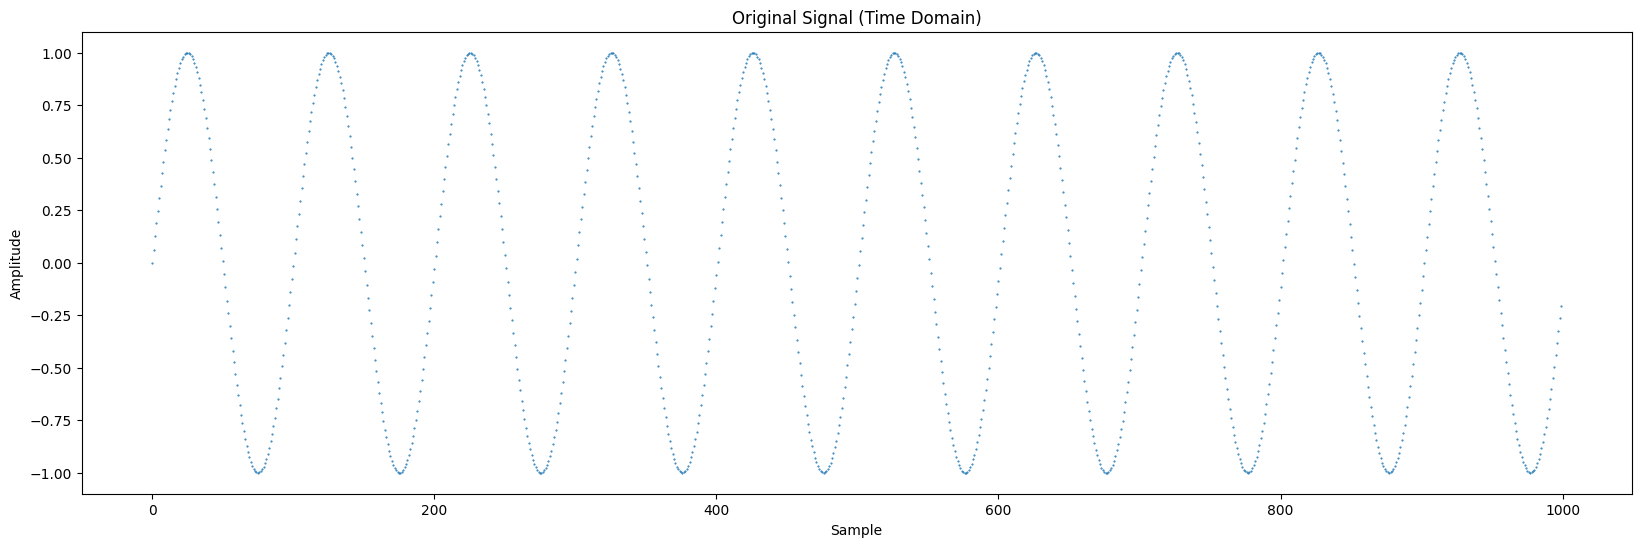

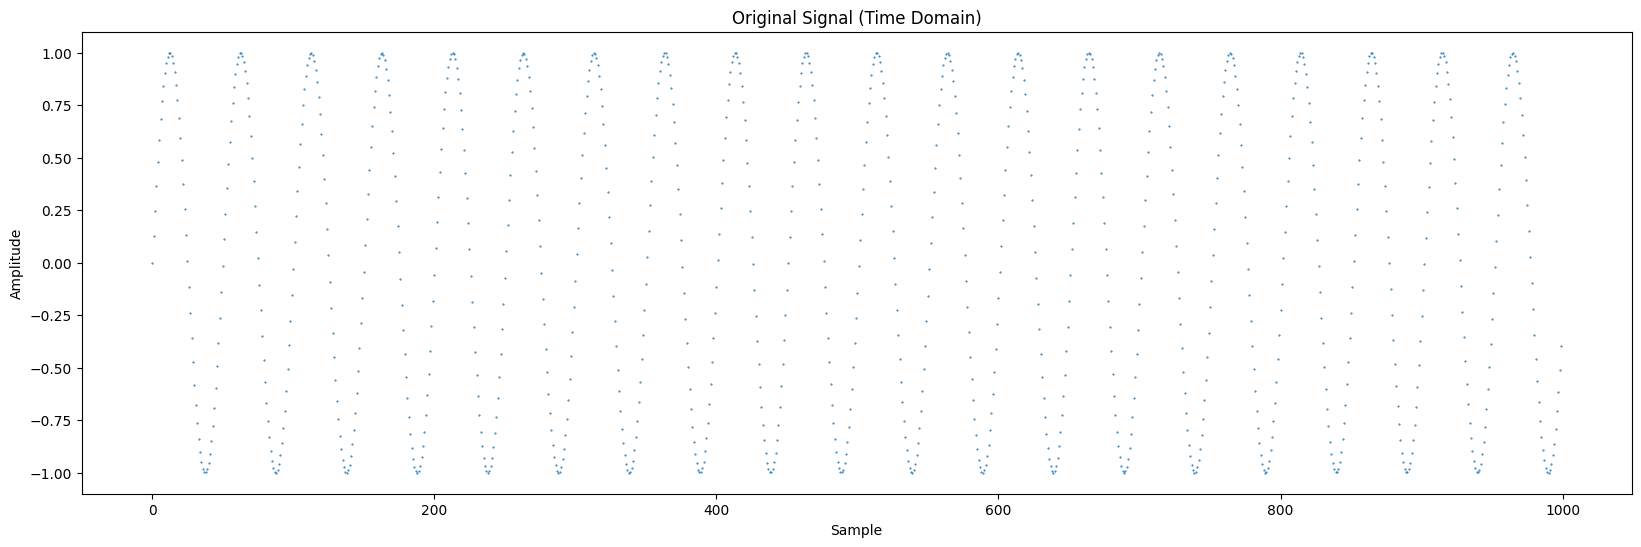

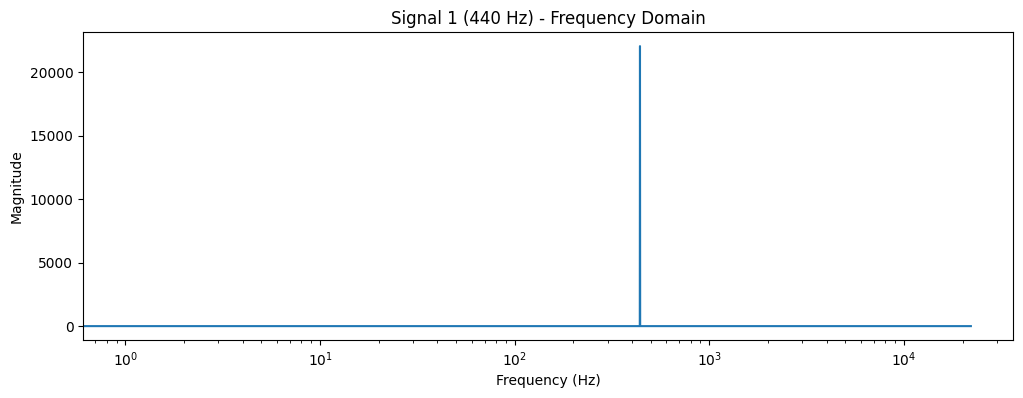

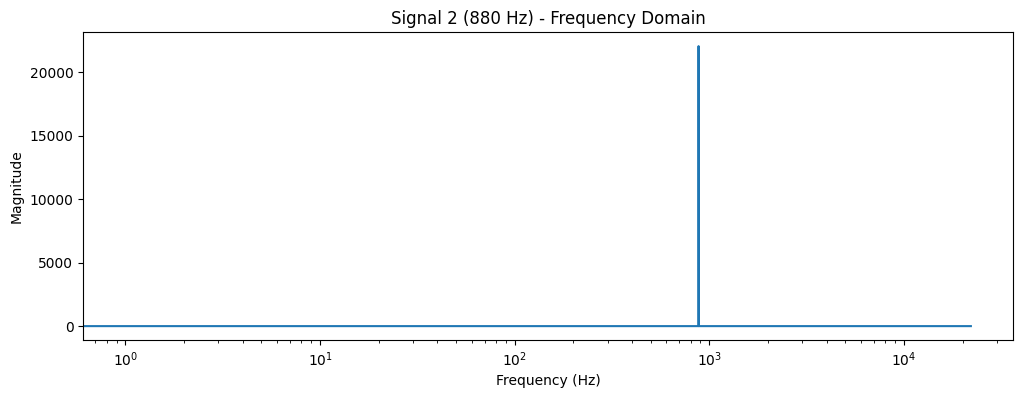

Spectral distance between 440 Hz and 880 Hz signals: 10.50191879272461


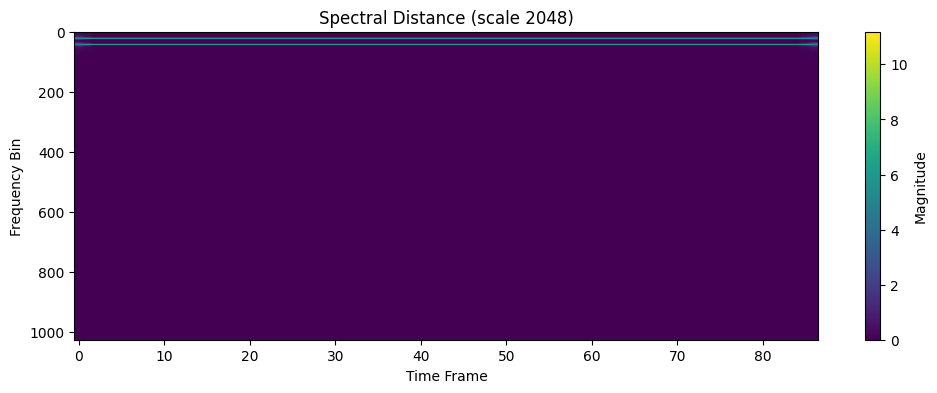

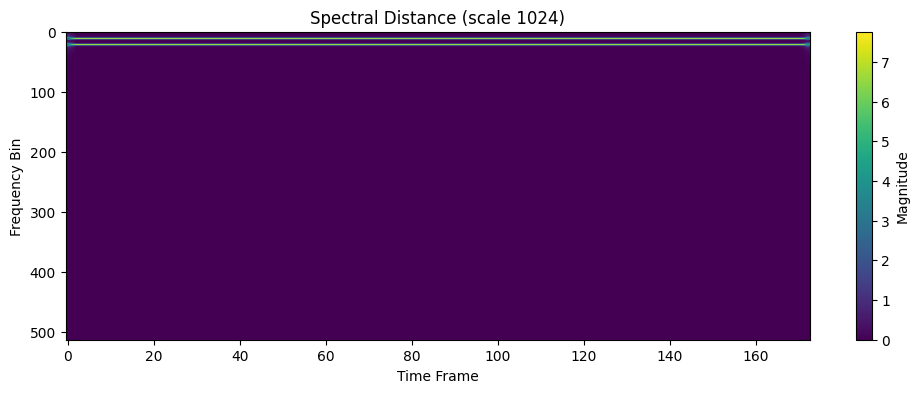

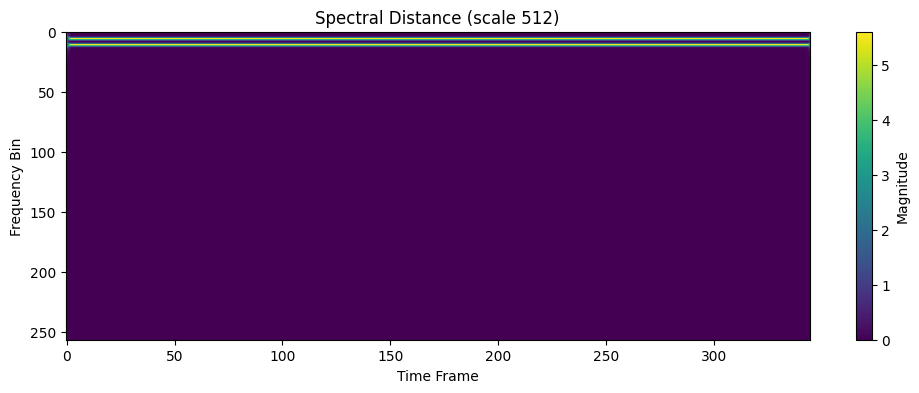

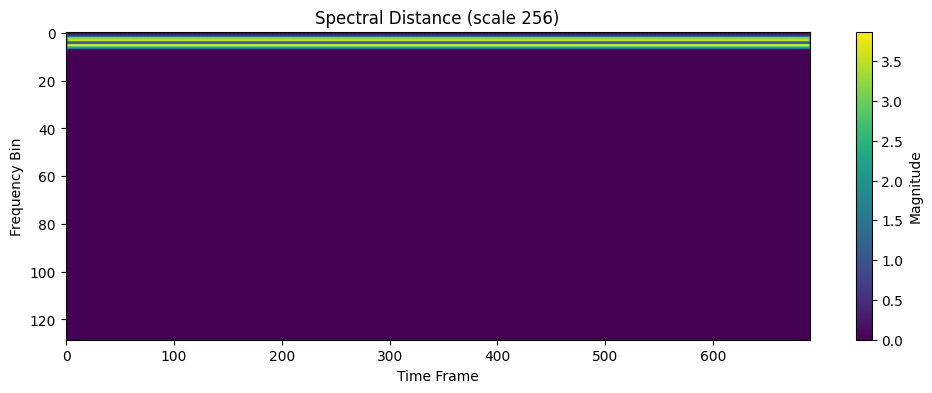

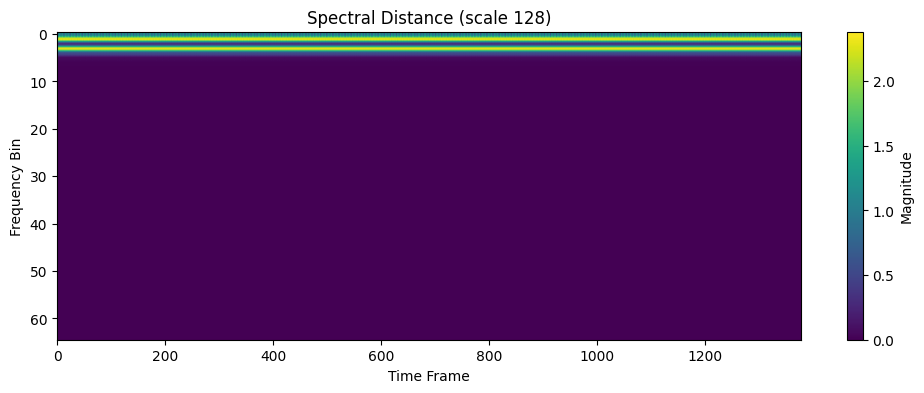

In [ ]:
print("\nPart 2: Spectral Distance Between Two Sinusoidal Signals")
scales = [2048, 1024, 512, 256, 128]
signal1 = generate_sine_wave(440)  # 440 Hz (A4 note)
signal2 = generate_sine_wave(880)  # 880 Hz (A5 note)

plot_time_domain(signal1, "Signal 1 (440 Hz) - Time Domain")
plot_time_domain(signal2, "Signal 2 (880 Hz) - Time Domain")

plot_frequency_domain(signal1, title="Signal 1 (440 Hz) - Frequency Domain")
plot_frequency_domain(signal2, title="Signal 2 (880 Hz) - Frequency Domain")

distance = spectral_distance(signal1, signal2)
print(f"Spectral distance between 440 Hz and 880 Hz signals: {distance.item()}")

x_stfts = multiscale_stft(signal1, scales, .75)
y_stfts = multiscale_stft(signal2, scales, .75)

plot_spectral_distance(x_stfts, y_stfts, scales)

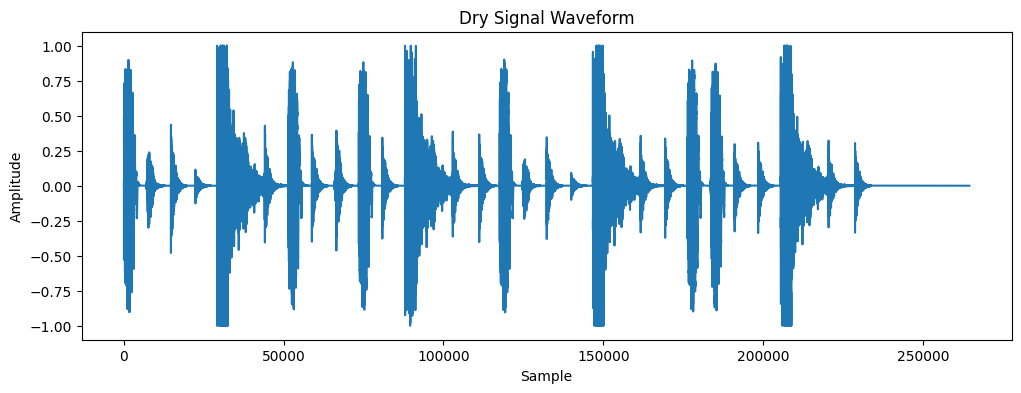

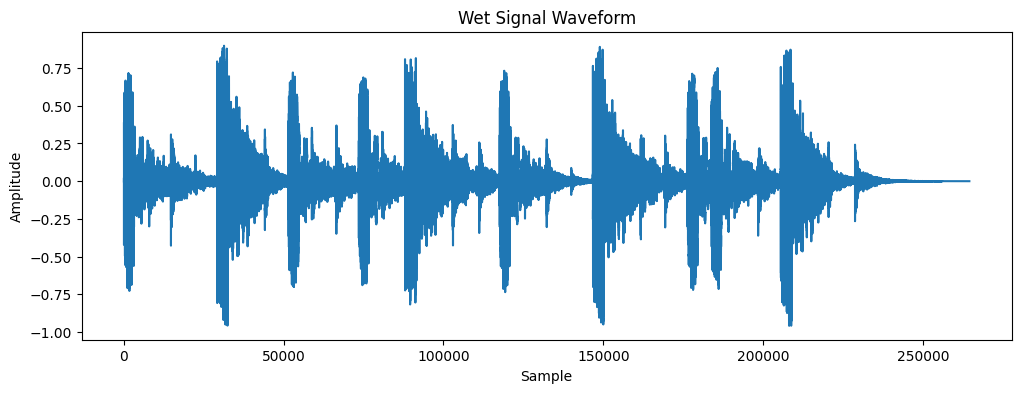

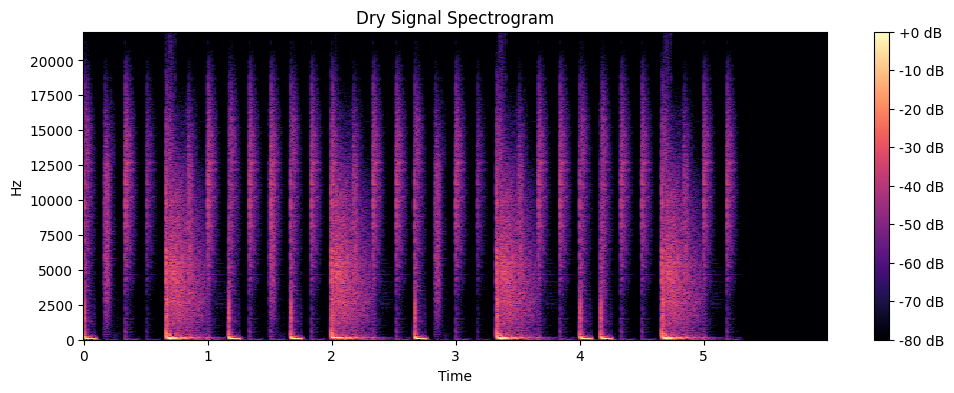

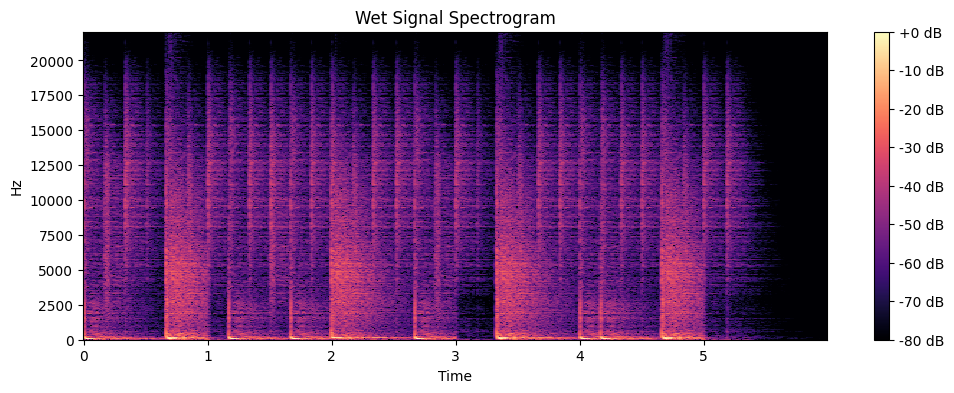

Spectral distance between dry and wet signals: 14.198342323303223


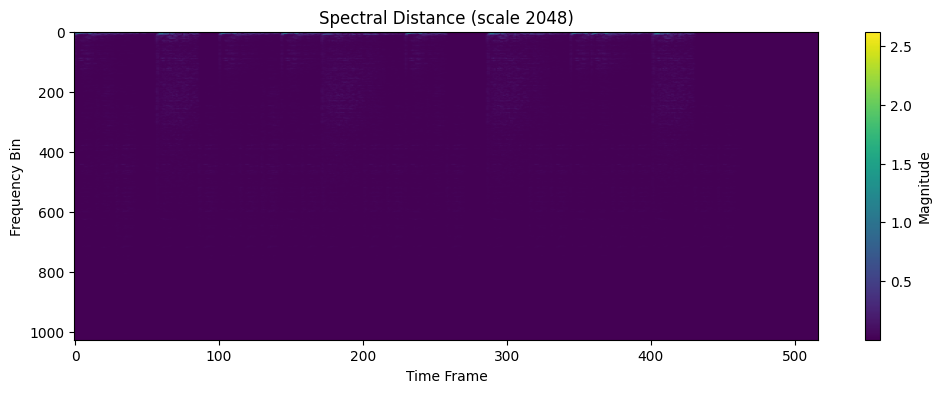

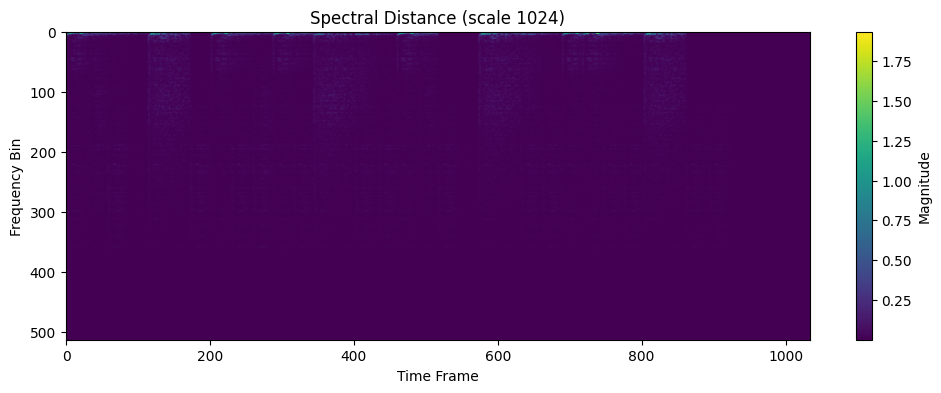

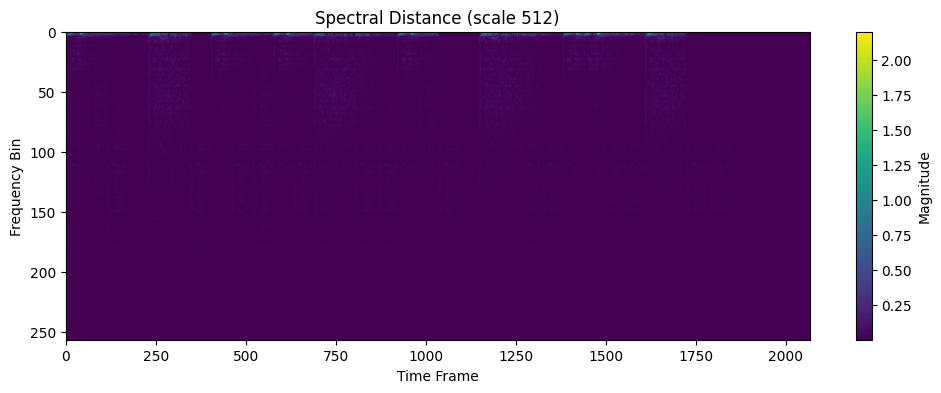

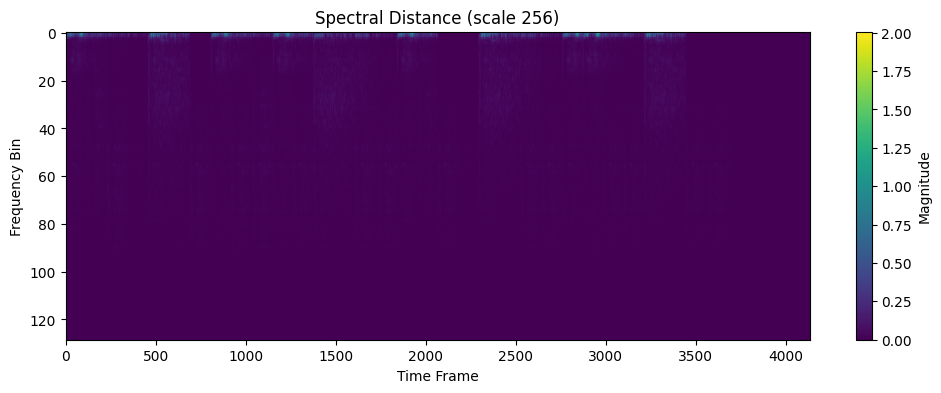

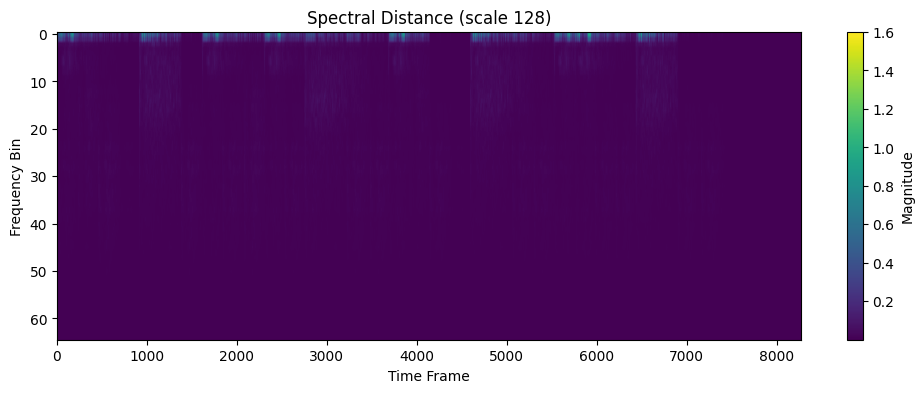

In [ ]:
# Load audio files
dry_signal = load_audio("80s Beat 90 bpm_dry.wav")
wet_signal = load_audio("80s Beat 90 bpm_wet.wav")

# Plot waveforms
plot_waveform(dry_signal, "Dry Signal Waveform")
plot_waveform(wet_signal, "Wet Signal Waveform")

# Plot spectrograms
sr = 44100  # Assuming 44.1 kHz sample rate
plot_spectrogram(dry_signal.squeeze(), sr, "Dry Signal Spectrogram")
plot_spectrogram(wet_signal.squeeze(), sr, "Wet Signal Spectrogram")

# Calculate spectral distance
distance = spectral_distance(dry_signal, wet_signal)
print(f"Spectral distance between dry and wet signals: {distance.item()}")

# Visualize spectral distance
scales = [2048, 1024, 512, 256, 128]
x_stfts = multiscale_stft(dry_signal, scales, .75)
y_stfts = multiscale_stft(wet_signal, scales, .75)

plot_spectral_distance(x_stfts, y_stfts, scales)